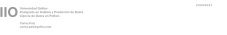

In [1]:
# This allows to show images in the notebook
from IPython.display import SVG

SVG(filename='../res/iio-header-w.svg')

# Project I

## Introduction

The goal of this project is to analyze house prices using a uni-variate linear regression model. We will train this model on a dataset that includes information about different features of houses, including square footage, number of rooms, and lot frontage.

To achieve our goal, we will explore the data using popular libraries such as scikit-learn. We will manually develop and implement the linear regression model, and compare its performance with the model trained using scikit-learn. This will help us determine which approach yields better predictions.

Through this project, we aim to gain a better understanding of how linear regression models work and how they can be used for analyzing real-world data. Our ultimate goal is to be able to accurately predict house prices based on their features, and provide valuable insights for real estate professionals and potential buyers alike.

## Regression fundamentals

*Regression is where models predict a number.<sup>1</sup>*

Supervised machine learning techniques involve training a model to predict a label using a set of features based on a dataset that includes known label values. In this context, the label is the variable we want to predict, and the features are the variables we use to make that prediction. The training process involves fitting the features to the known labels to define a general function that can be applied to new features for which the labels are unknown, and predict them. By learning from the relationship between the features and the labels in the training data, the model can make accurate predictions on new data, where the label values are not yet known.

In general, the equation for linear regression is:
</br>
<div style="text-align:center">$y = β_0 + β_1 x_i + ε_i$</div>

where $y$ represents the dependent variable that we are trying to predict using one or more independent variables ($x_i$). The coefficients ($β_i$) of the regression model are the foundations of our model, and they represent the weights assigned to each independent variable in predicting the dependent variable. These coefficients are learned during model optimization.<sup>2</sup> The $ε_i$ are assumed to be independent with expectation $0$ and unknown variance $σ^2$. The unknown line defined by the formula is called the regression line.<sup>3</sup>


### Model evaluation

In order to effectively train a linear regression model, it is necessary to have a method for evaluating its performance. This is typically achieved through the use of a loss function, which is a function used to quantify how well the model is performing. There are several common loss functions used in machine learning, including:

#### Mean Square Error (MSE)

It measures the average squared differences between predicted and actual values. Smaller values indicate a better fit of the model. In general, the formula for the mean square error is:

</br><div style="text-align:center"> $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$</div></b>

where $n$ is the total number of observations, $y$ is the actual value of the dependent variable and $\hat{y}$ is the predicted value of the dependent variable. By squaring the errors, we prevent the positive and negative terms from canceling each other out in the sum. This approach gives more weight to the points further away from the regression line, which helps to identify and penalize outliers.<sup>4</sup>

For this project, we will be using mean-squared error (MSE) as our performance-measuring metric.

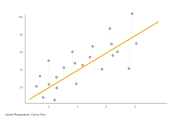

In [41]:
SVG(filename='../res/project01/regression.svg')

#### Root Mean Square Error (RMSE)

This is the square root of the MSE and provides an absolute metric in the same unit as the label. The smaller the value, the better the model (in simple terms, it represents the average magnitude of prediction error).

#### Coefficient of Determination (R2)

It is a relative metric where higher values indicate a better fit of the model. This metric represents how much of the variance between predicted and actual label values the model can explain.

### Optimization

In linear regression, the model learns the coefficients through a process called optimization. The goal of optimization is to minimize the difference between the predicted values and actual values of the dependent variable. This is done by adjusting the coefficients until the error is minimized.

#### Gradient descent

Gradient descent is a popular optimization algorithm used to find the optimal coefficients for a linear regression model. It works by iteratively adjusting the coefficients in the direction of the negative gradient of the cost function, which is the function that measures the difference between predicted and actual values. By repeatedly adjusting the coefficients using gradient descent, the model slowly converges to the optimal coefficients that minimize the cost function and produce the most accurate predictions.<sup>5</sup>

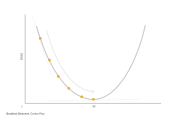

In [3]:
SVG(filename='../res/project01/gradient-descent.svg')

To find the coefficients that minimize the error function, we calculate the derivative of the loss function (MSE).

</br><div style="text-align:center"> $\frac{δ}{δβ_i}MSE = -\frac{2}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})$</div></b>

By finding the derivatives, we can determine the slope of the error curve at each point, which tells us in which direction the coefficients should be adjusted. <sup>4</sup>

</br><div style="text-align:center"> $β_i = β_i-\alpha(-\frac{2}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i}))$</div></b>

The learning rate $\alpha$ determines the step size in each iteration of the algorithm. If the learning rate is too small, the algorithm may take a long time to converge to the optimal values of the coefficients. If the learning rate is too large, the algorithm may overshoot the minimum and fail to converge. In the end, this allows us to update the coefficients iteratively, using the gradient descent algorithm, until we reach a minimum point of the error curve.

## Setting up the environment

In [4]:
# Setting up the environment
import pandas as pd
from experiment import PreprocessData
from experiment import CustomModel
from plotter import DataPlotter

%matplotlib inline

## Exploring the data

Exploring the data is a crucial first step in training any machine learning model. The objective of data exploration is to identify the relationships between various attributes, specifically any correlation between the features and the label that the model will predict. This may involve addressing data issues such as missing values, errors or outliers, creating new feature columns through feature engineering, normalizing numeric features to ensure they are on the same scale, and encoding categorical features as numeric indicators.

Let's start by loading the House Prices data:

In [5]:
data = PreprocessData()

house_prices = data.load_data('data/proyecto_training_data.npy')

Data loaded!


The data consists of the following information:

* **SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.
* **OverallQual**: Overall material and finish quality, rates the overall material and finish of the house.
* **FloorSquareFeet**: First Floor square feet.
* **TotalRooms**: Total rooms above grade (does not include bathrooms)
* **YearBuilt**: Original construction date.
* **LotFrontage**: Linear feet of street connected to property.

In this dataset, **SalePrice** represents the label ($y$) our model must be trained to predict. The other columns are potential features ($x$).

In order to visualize the data more effectively, we can present it as a Pandas dataframe:

In [6]:
df = pd.DataFrame(house_prices, columns=['SalePrice','OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage'])

df.head()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0


Now that we have an idea of the structure of the information, it's important to know some statistics about the data. To do so, we use the ```describe()``` method to check the **mean**, **min** and **max** values.

In [7]:
df.describe()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000
mean,180921.195890,6.099315,1162.626712,6.517808,1971.267808,70.049958
std,79442.502883,1.382997,386.587738,1.625393,30.202904,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,129975.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,163000.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,214000.000000,7.000000,1391.250000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


At first glance, we can observe that the mean of the sale prices is around USD181000, while the standard deviation is around USD83000, indicating a large variation in prices. To have a clearer idea of the price distribution, we can visualize the data using histograms and box plots as follows:

/Users/carlos/Workspace/code/g-labs/project01/plotter.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


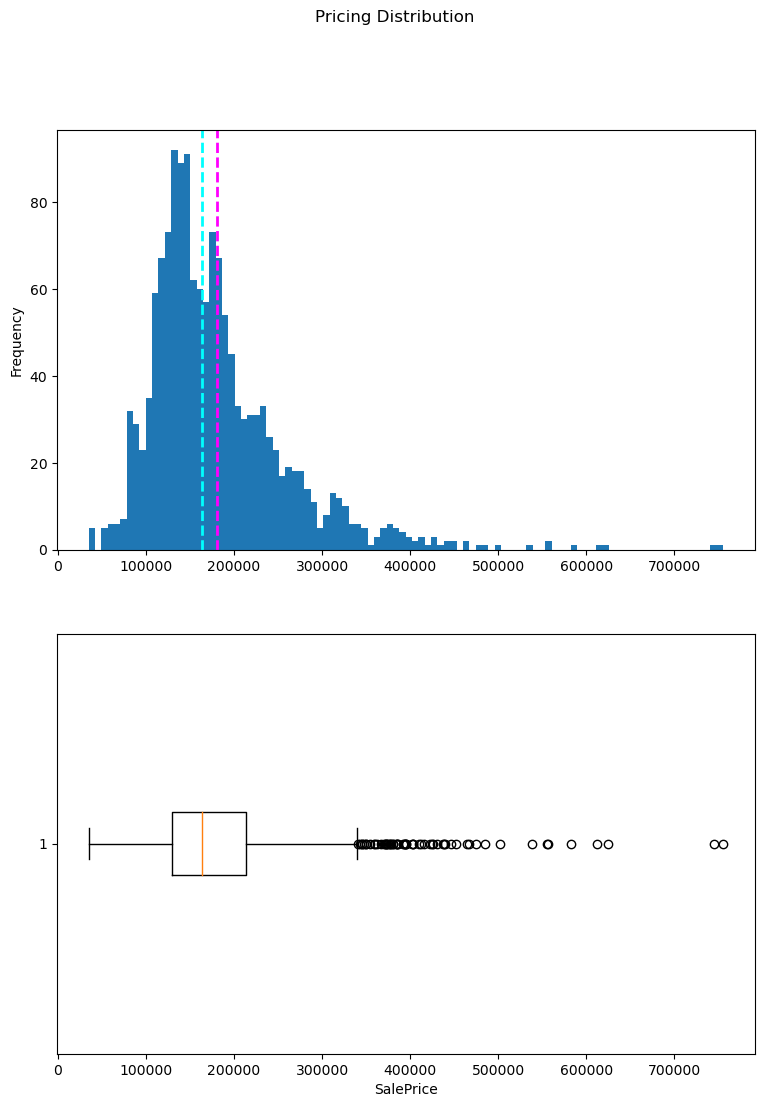

In [8]:
DataPlotter.plot_distribution(df, target='SalePrice', title='Pricing Distribution')

From these plots, we can observe that the majority of the data falls within the price range of USD30,000 to USD340,000, with the mean close to the middle of this range. Prices above USD340,000 appear to be unusual, indicating that they are **outliers**.

We will perform the same kind of exploration for the numeric features.

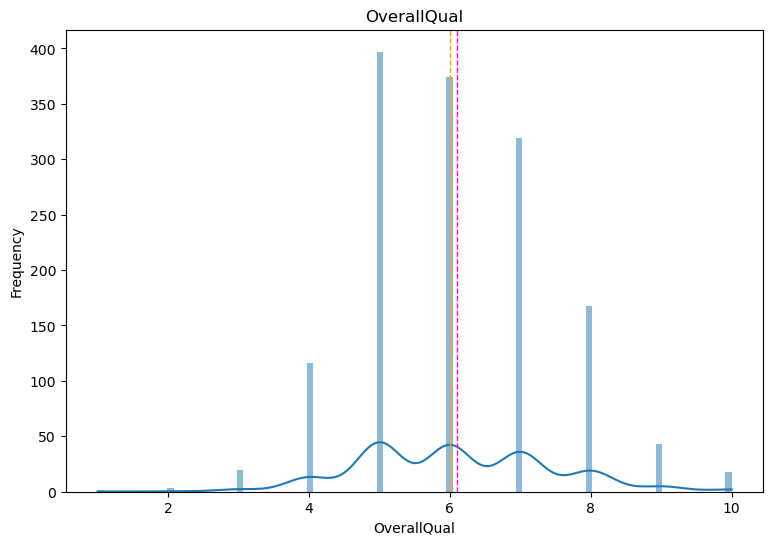

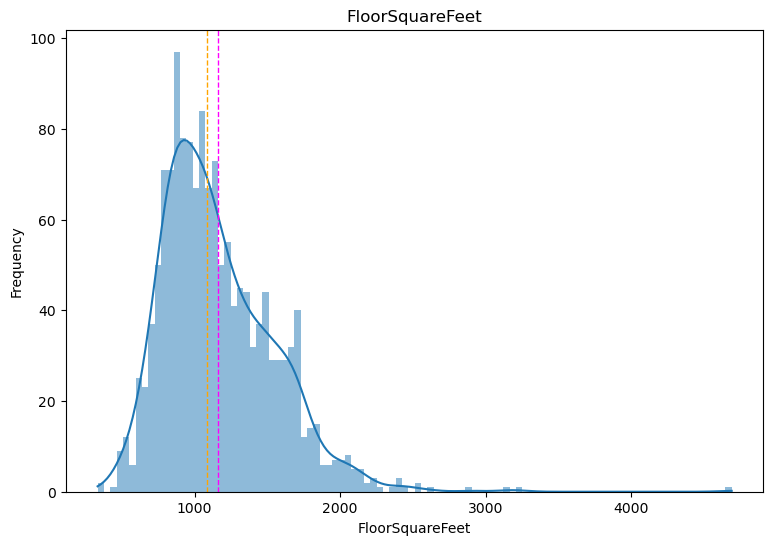

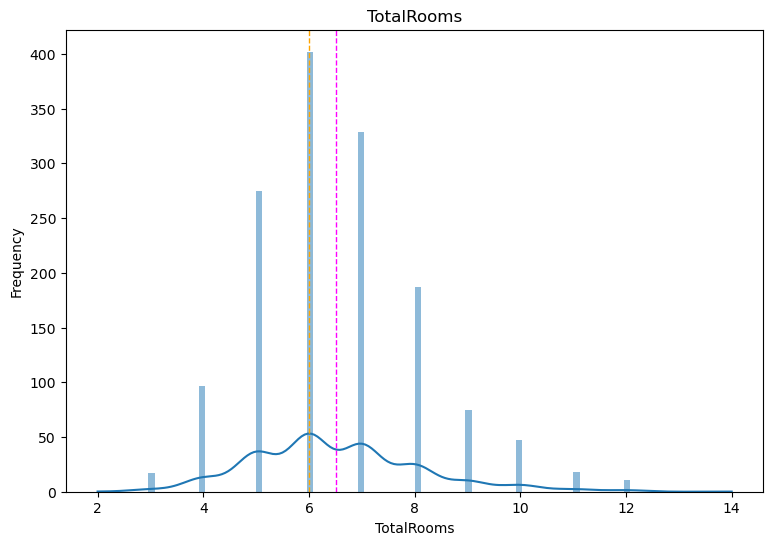

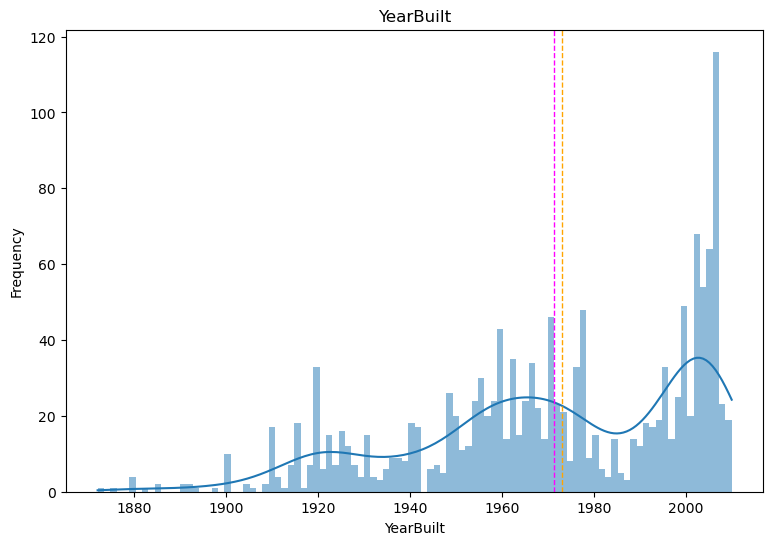

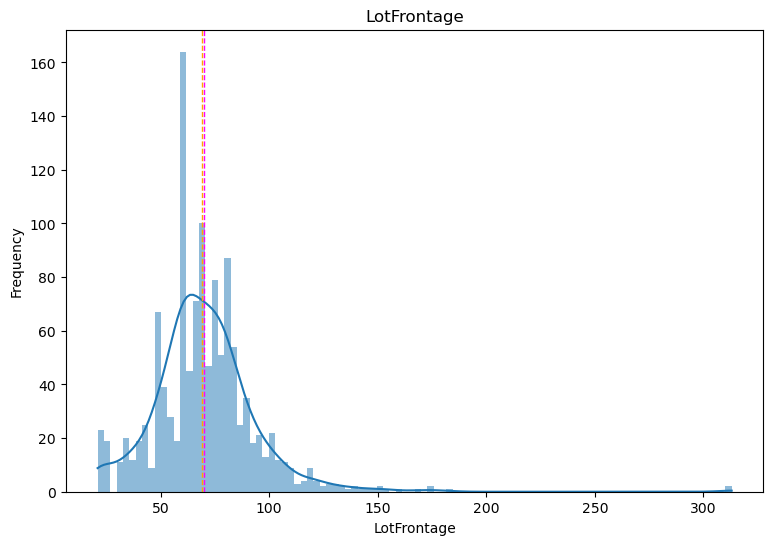

In [9]:
features = ['OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage']

for col in features:
    DataPlotter.plot_features(df, feature=col)

As we can see, some features seems to be more normally distributed than the label.

Now that we know more about the data in columns, we can analyze the relationship between the features and the label values. We can also calculate the correlation statistic to quantify the apparent relationship.

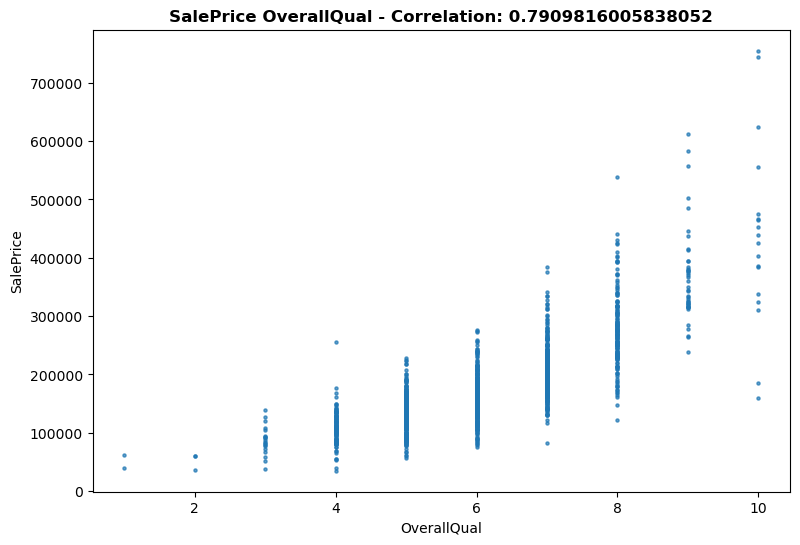

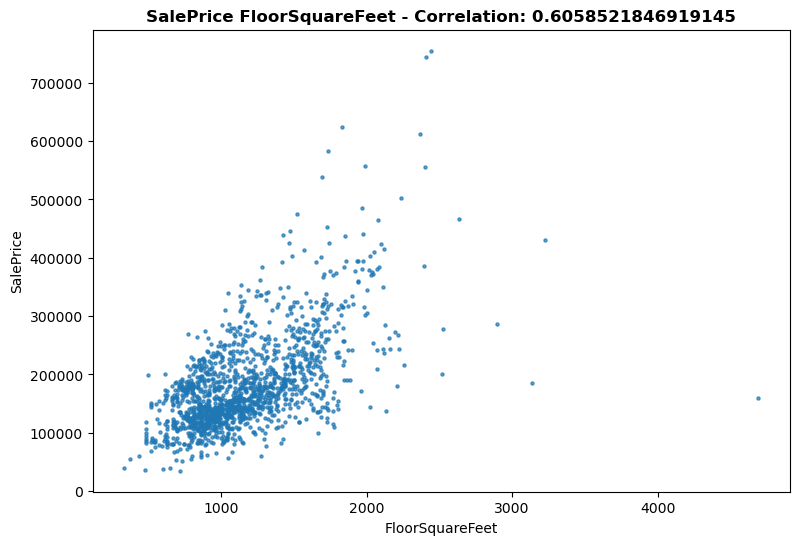

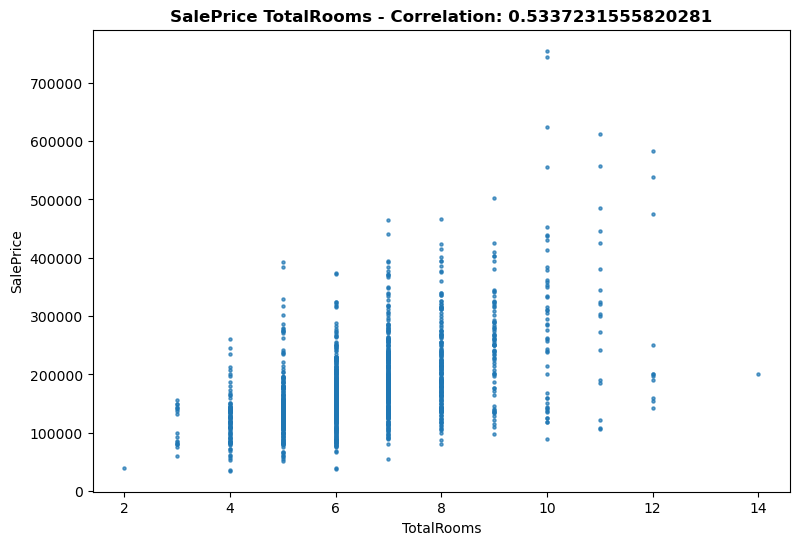

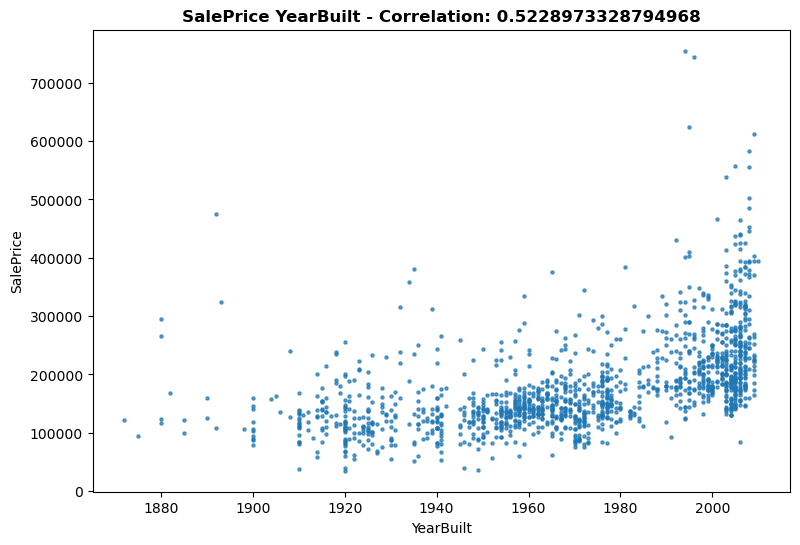

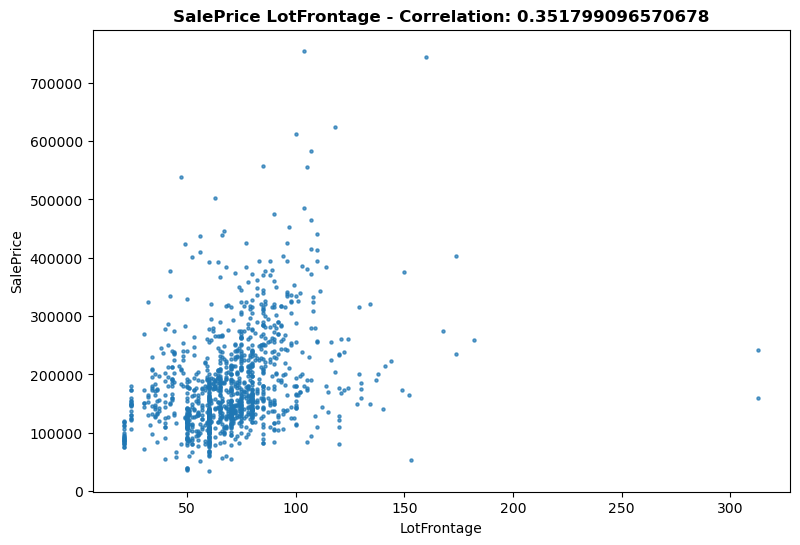

In [10]:
for col in features:
    DataPlotter.plot_correlation(df, feature=col, target='SalePrice')

Although the results may not seem very conclusive, a trend can be observed where the **OverallQual** rate coincides with high house prices. The same behavior is observed with the **FloorSquareFeet** of the property. In both cases, a correlation above 0.6 is observed, which indicates a positive correlation.

### Selected features

As **OverallQual** and **FloorSquareFeet** features have shown the strongest correlation with the target variable, we will be focusing on training and evaluating our model based on these features. To ensure consistency and clarity, we will be referring to them as **Feature 1** (OverallQual) and **Feature 2** (FloorSquareFeet) throughout the remainder of this project.

In [11]:
# Selected features
FEATURE1 = "OverallQual"
FEATURE2 = "FloorSquareFeet"

## Train the regression model

Now that we've explored the data, it's time to use it to train a regression model that uses the features we've identified as potentially predictive to predict the rentals label. The first thing we need to do is to separate the features we want to use to train the model from the label we want it to predict.

### Training on Feature 1

In [12]:
# Assign values to the label y - SalePrice
y = house_prices[:,0]

# Assign values to the feature X - OverallQual
X_f1 = house_prices[:,1]

# Split the data into training and testing sets
preprocess = PreprocessData()
X_train_f1, y_train_f1, X_test_f1, y_test_f1 = preprocess.split_data(X_f1, y, 0.8)

Total elements for X_train: 1168, X_test: 292
Total elements for y_train: 1168, y_test: 292


Now we're ready to train a model by fitting a uni-variate regression algorithm to the training data. We'll use a linear regression algorithm in order to find a linear relationship between the X values and the y label. The resulting model is a dictionary that conceptually defines a line where every possible X and y value combination intersect.

In [13]:
# Create an instance of the CustomModel class and train the model
model_f1 = CustomModel()
model_dict_f1, errors_f1 = model_f1.train(X_train_f1, y_train_f1, epochs=250, print_error_interval=25, alpha=0.001)

Epoch 25, error: 3551540509.0443926
Epoch 50, error: 2912702213.360592
Epoch 75, error: 2900691978.5407176
Epoch 100, error: 2898075141.0004835
Epoch 125, error: 2895610272.150638
Epoch 150, error: 2893158998.9921665
Epoch 175, error: 2890719197.607315
Epoch 200, error: 2888290783.6158247
Epoch 225, error: 2885873703.409406
Epoch 250, error: 2883467904.084649


#### Error level analysis

As a result of the training function, we have obtained the error through the **Mean Squared Error (MSE)** function with the values calculated for the gradient descent at each iteration. These error values are shown in the following graph:

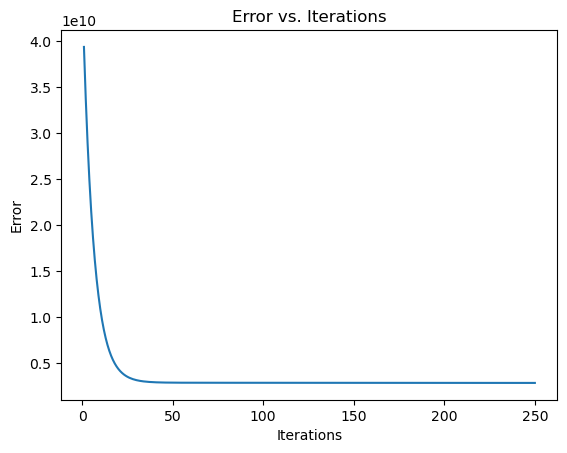

In [14]:
DataPlotter.plot_error(errors_f1)

As can be seen from the graph, as the weights were updated at each iteration, the calculation of the gradient descent improved the model, obtaining error measures that approach zero. **The lower the value, the better the model prediction will be.**

#### Model evolution in each epoch

In the following graph we can observe how the predictability of the model evolves in each iteration.

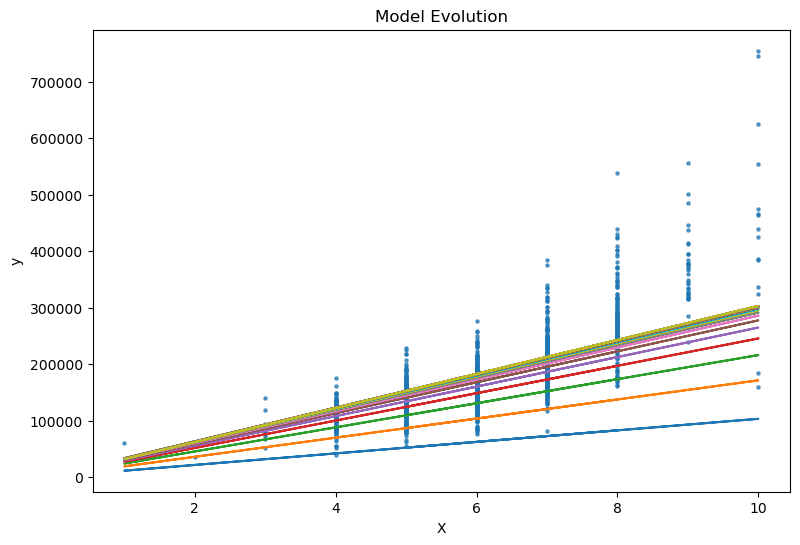

In [15]:
DataPlotter.plot_evolution(model_dict_f1,n=5,X=X_train_f1,y=y_train_f1)

### Training on Feature 2

In [16]:
# Assign values to the label y - SalePrice
y = house_prices[:,0]

# Assign values to the feature X - FloorSquareFeet
X_f2 = house_prices[:,2]

# Split the data into training and testing sets
X_train_f2, y_train_f2, X_test_f2, y_test_f2 = preprocess.split_data(X_f2, y, 0.8)

Total elements for X_train: 1168, X_test: 292
Total elements for y_train: 1168, y_test: 292


In [17]:
# Training the model with the data
model_f2 = CustomModel()
model_dict_f2, errors_f2 = model_f2.train(X_train_f2, y_train_f2, epochs=30, print_error_interval=10, alpha=0.001)

Epoch 10, error: 9.745545490967095e+72
Epoch 20, error: 2.4305415002514902e+142
Epoch 30, error: 6.061776623915262e+211


#### Error level analysis

As the evaluation for the Feature 1, we can observe how the obtained MSE changes with the values calculated for the gradient descent at each iteration. The errors and model prediction are shown in the following graphs:

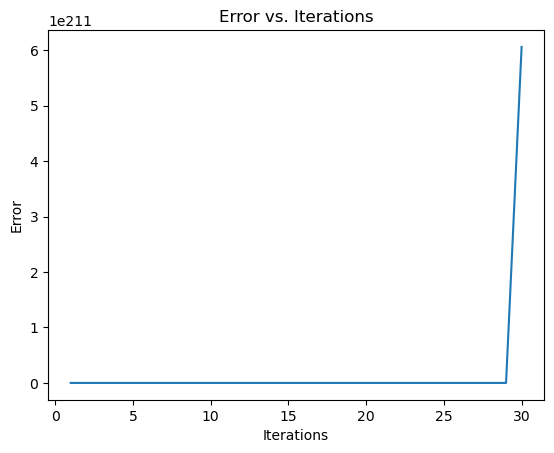

In [18]:
DataPlotter.plot_error(errors_f2)

#### Model evolution in each epoch

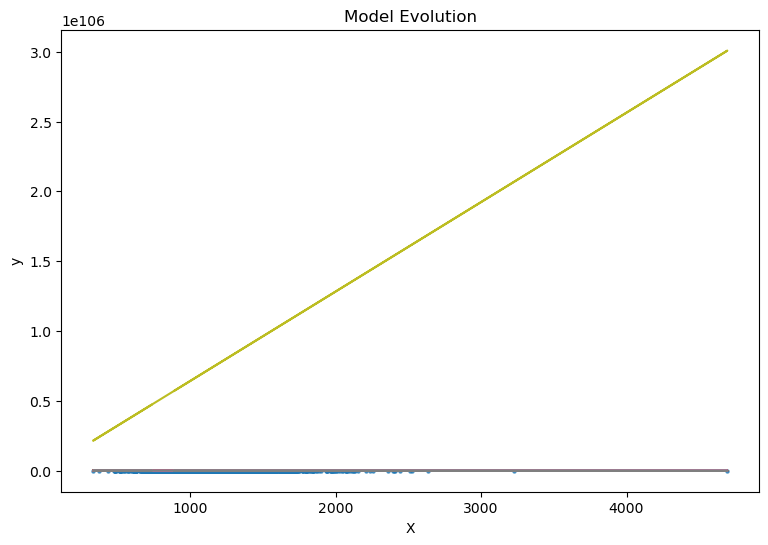

In [19]:
DataPlotter.plot_evolution(model_dict_f2,n=1,X=X_train_f2,y=y_train_f2)

#### Model validation

Unlike Feature 1, our model does not perform well on Feature 2. This is mainly because the data for this feature is affected by outliers, as we saw in the data exploration section. Since feature engineering is not the focus of this project, we did not apply techniques such as scaling and normalization to address this issue. However, we have developed a data transformation function to validate our model on this feature.

In [20]:
# Implementation for scaling and normalization feature

# Assign values to the feature X - FloorSquareFeet
X_f2_v2 = preprocess.scale_and_normalize(X_f2)

# Split the data into training and testing sets
X_train_f2_v2, y_train_f2_v2, X_test_f2_v2, y_test_f2_v2 = preprocess.split_data(X_f2_v2, y, 0.8)

Total elements for X_train: 1168, X_test: 292
Total elements for y_train: 1168, y_test: 292


In [21]:
# Training the model with the data
model_f2_v2 = CustomModel()
model_dict_f2_v2, errors_f2_v2 = model_f2_v2.train(X_train_f2_v2, y_train_f2_v2, epochs=5000, print_error_interval=500, alpha=0.001)

Epoch 500, error: 8626826379.808485
Epoch 1000, error: 4584266771.54473
Epoch 1500, error: 4043207603.831029
Epoch 2000, error: 3970767886.904215
Epoch 2500, error: 3961066056.2786846
Epoch 3000, error: 3959766255.4520164
Epoch 3500, error: 3959592055.8197875
Epoch 4000, error: 3959568701.565779
Epoch 4500, error: 3959565569.4771194
Epoch 5000, error: 3959565149.280822


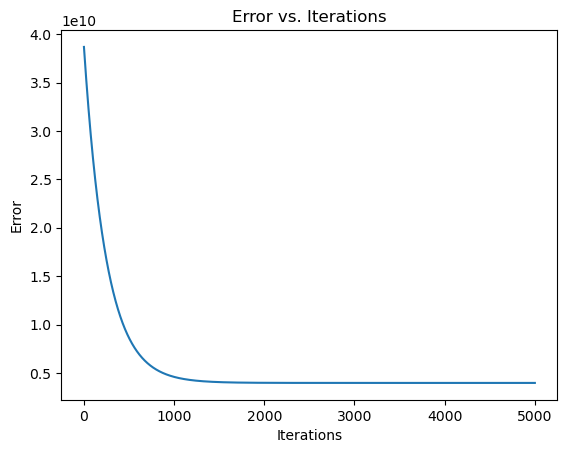

In [22]:
DataPlotter.plot_error(errors_f2_v2)

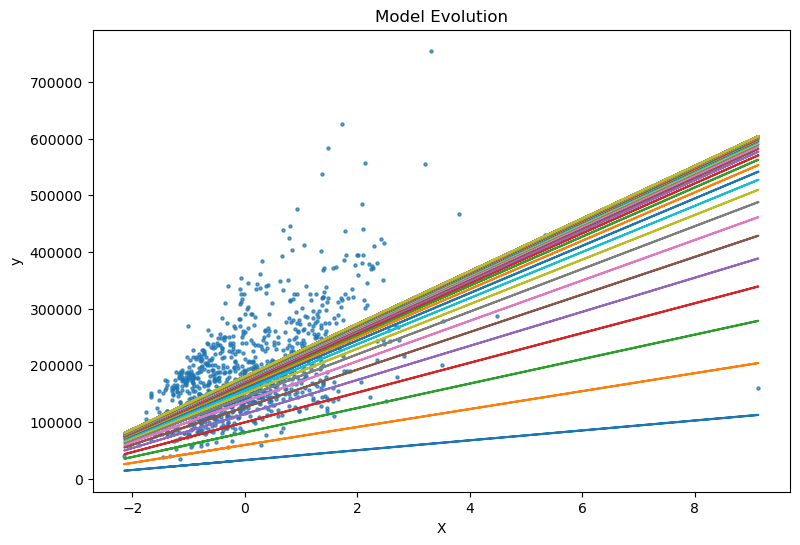

In [23]:
DataPlotter.plot_evolution(model_dict_f2_v2,n=100,X=X_train_f2_v2,y=y_train_f2_v2)

As can be observed, with the applied scaling and normalization techniques, our model has improved in training for Feature 2. However, it is important to emphasize that this has been done solely for model validation purposes.

## Model evaluation

After training the model, we can use it to predict the sale price of houses using the features we reserved for our validation dataset. We can then compare these predictions to the actual label values to evaluate how well the model is performing.

### Evaluation of Feature 1

We can predict and obtain error metrics as follows:

In [24]:
custom_predictions_f1 = model_f1.predict_from_custom_model(model_dict_f1, X_test_f1, y_test_f1)

Metrics for the Custom Model:
MSE: 2636472520.382998
RMSE: 51346.59210096613
R2: 0.5552883846225336


Although the model is not entirely optimal, it provides a useful indication of the accuracy of its predicted values, based on the results and definitions of the error metrics.

### Evaluation of Feature 2

In [25]:
custom_predictions_f2 = model_f2.predict_from_custom_model(model_dict_f2, X_test_f2, y_test_f2)

Metrics for the Custom Model:
MSE: 5.7311809349047246e+218
RMSE: 2.3939884993259103e+109
R2: -8.616528958261628e+208


The results suggest that the linear regression model is not a good fit for the data. The mean squared error (MSE) is an extremely large value, which means that the predicted values are very far away from the actual values, on average. The root mean squared error (RMSE) is even larger than the MSE, which indicates that the errors are very large and the model is not fitting the data well at all. The R-squared value (R2) is also a negative value, which means that the model is performing worse than simply predicting the mean of the target variable.

Again, we can check with the transformed data to validate our model:

In [26]:
custom_predictions_f2_v2 = model_f2_v2.predict_from_custom_model(model_dict_f2_v2, X_test_f2_v2, y_test_f2_v2)

Metrics for the Custom Model:
MSE: 4138611525.1231775
RMSE: 64332.04120127992
R2: 0.4110227279181933


### Predictions vs actual labels

To analyze the results obtained from the predictions more efficiently, we can visualize them as a scatter plot that compares the predicted values with the actual values.

#### Predictions on Feature 1

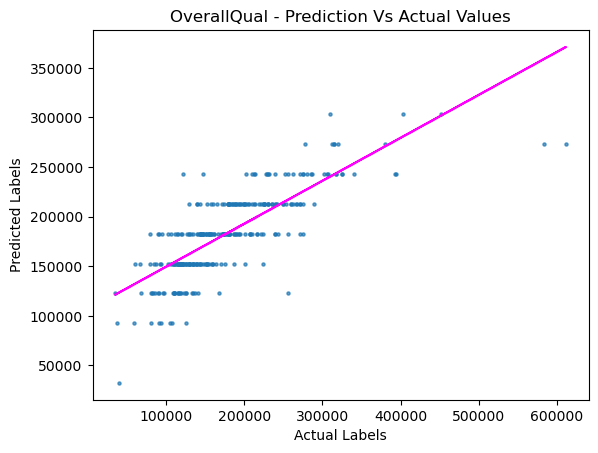

In [27]:
# Plot for the feature OverallQual
DataPlotter.plot_predictions(custom_predictions_f1,y_test_f1, title=FEATURE1+" - Prediction Vs Actual Values")

As seen in the plot, there is a positive trend between the predicted values and the actual values, as indicated by the obtained error metrics. The predicted and actual values show a clear diagonal trend, with the intersections generally following the path of the trend line. However, there are noticeable differences between the ideal function represented by the line and the actual results. These differences are known as the residuals of the model. They represent the difference between the predicted label and the actual value of the validation label, when the model applies the coefficients learned during training to the validation data. 

#### Predictions on Feature 2

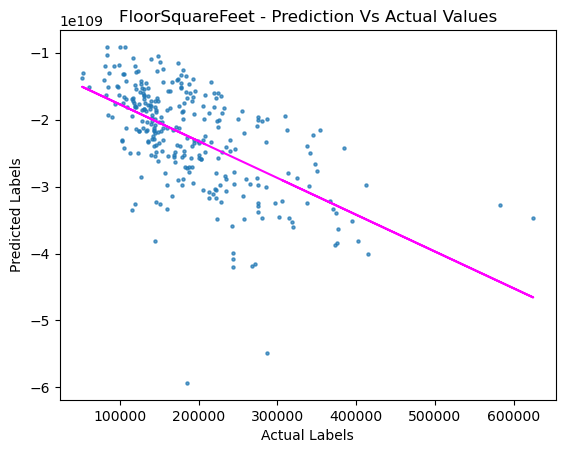

In [28]:
# Plot for the feature FloorSquareFeet
DataPlotter.plot_predictions(custom_predictions_f2,y_test_f2, title=FEATURE2+" - Prediction Vs Actual Values")

In this graph, a poor performance of the model on the training set is observed, indicating a high level of variation between the predicted and actual values.

## Scikit-learn implementation

Since we have trained our model and analyzed the data manually, we will now use scikit-learn to train a linear regression model with the variables selected previously. Scikit-learn is a machine learning library in Python that provides a range of supervised and unsupervised learning algorithms through a consistent interface for building machine learning models.

It's important to mention that the methods used in the following implementation have been custom-made for the purpose of this project, and the implementation of the scikit-learn modules can be consulted in the **Experiment.py**.

### Implementation on the Feature 1

In [29]:
# Train the linear regression model 
skl_model_f1 = model_f1.train_with_skl(X_train_f1, y_train_f1)

Trained!


In [30]:
# Get the predictions
skl_predictions_f1 = model_f1.predict_from_skl_model(skl_model_f1, X_test_f1, y_test_f1)

Metrics for the Scikit-learn Model:
MSE: 2329393395.0156
RMSE: 48263.789687669574
R2: 0.6070854933862528


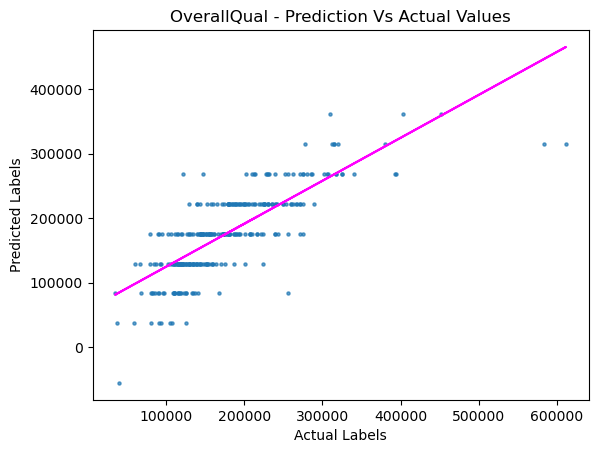

In [31]:
# Plot for the feature OverallQual
DataPlotter.plot_predictions(skl_predictions_f1,y_test_f1, title=FEATURE1+" - Prediction Vs Actual Values")

### Implementation on the Feature 2

In [32]:
# Train the linear regression model 
skl_model_f2 = model_f2.train_with_skl(X_train_f2, y_train_f2)

Trained!


In [33]:
# Get the predictions
skl_predictions_f2 = model_f2.predict_from_skl_model(skl_model_f2, X_test_f2, y_test_f2)

Metrics for the Scikit-learn Model:
MSE: 4438051838.325626
RMSE: 66618.70486826974
R2: 0.332762259339929


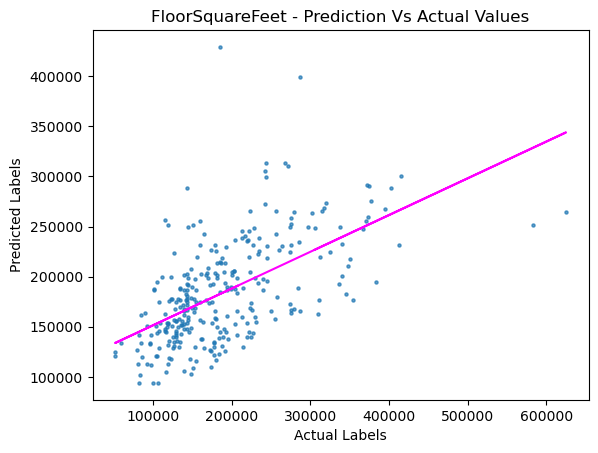

In [34]:
# Plot for the feature OverallQual
DataPlotter.plot_predictions(skl_predictions_f2,y_test_f2, title=FEATURE2+" - Prediction Vs Actual Values")

## Average level of error between the models

After obtaining the predicted values from both the manual and scikit-learn models, we can calculate the average prediction by taking the mean of the two. This allows us to obtain a more robust prediction and reduce the impact of any potential bias in one of the models.

### Average predictions for the Feature 1

In [35]:
# Average for the OverallQual feature
avg_predictions_f1 = model_f1.evaluate_models(custom_predictions_f1, skl_predictions_f1, y_test_f1)

Metrics for the avg predictions:
MSE: 2341891155.29055
RMSE: 48393.089953944356
R2: 0.6049774118047062


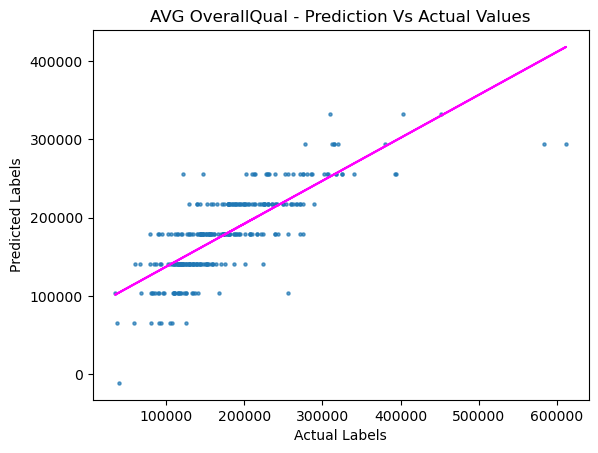

In [36]:
DataPlotter.plot_predictions(avg_predictions_f1,y_test_f1, title="AVG "+FEATURE1+" - Prediction Vs Actual Values")

### Average predictions for the Feature 2

In [37]:
# Average for the OverallQual feature
avg_predictions_f2 = model_f2.evaluate_models(custom_predictions_f2, skl_predictions_f2, y_test_f2)

Metrics for the avg predictions:
MSE: 1.4327952337261811e+218
RMSE: 1.1969942496629551e+109
R2: -2.154132239565407e+208


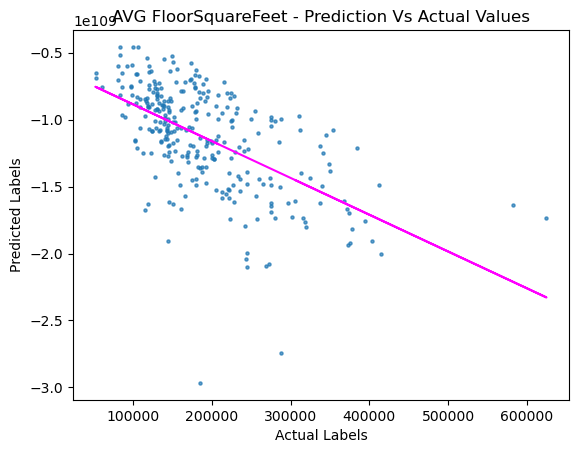

In [38]:
DataPlotter.plot_predictions(avg_predictions_f2,y_test_f2, title="AVG "+FEATURE2+" - Prediction Vs Actual Values")

To validate the model predictions using normalized values for Feature 2, we proceed as follows:

In [39]:
avg_predictions_f2_v2 = model_f2_v2.evaluate_models(custom_predictions_f2_v2, skl_predictions_f2, y_test_f2_v2)

Metrics for the avg predictions:
MSE: 5598770718.168191
RMSE: 74824.93379995863
R2: 0.20322342781373903


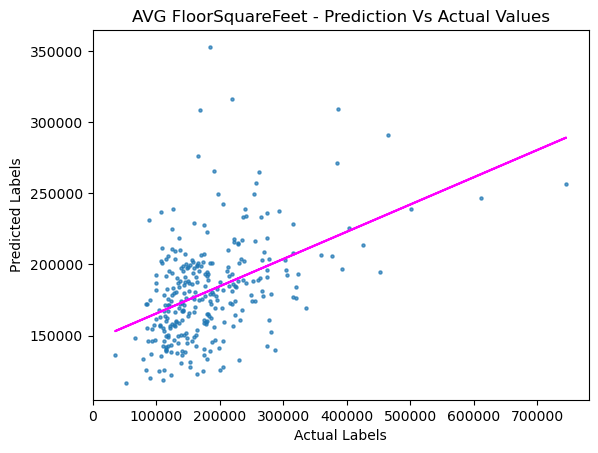

In [40]:
DataPlotter.plot_predictions(avg_predictions_f2_v2,y_test_f2_v2, title="AVG "+FEATURE2+" - Prediction Vs Actual Values")

## Conclusion

Based on the linear regression fundamentals, we conducted an analysis on a dataset with **SalePrice** as the target variable. To determine the most relevant features for the analysis, we identified the features with the highest correlation coefficients with the target variable, resulting in **OverallQual** and **FloorSquareFeet** as the top features.

To further analyze the impact of each feature on the target variable, we trained two different models for each feature. The first model was constructed manually, while the second model was a linear regression model developed through scikit-learn.

After evaluating the performance of our manually constructed linear regression model and the scikit-learn linear regression model on two features -FloorSquareFeet and OverallQual-, we found that the scikit-learn model outperformed our model for the **FloorSquareFeet** feature. We attribute this to the advanced preprocessing techniques implemented by scikit-learn, and we demonstrated this when we scaled and normalized the data for this feature. However, both models showed accurate results for the **OverallQual** feature. These results demonstrate the benefits of using a more advanced and automated approach in developing predictive models, such as the scikit-learn linear regression model.

## References

<sup>1</sup> Microsoft Ignite (2022). AI Automation Challenge Conference, Mexico City.
<sup>2</sup> Gelman, A., Hill, J., & Vehtari, A. (2020). Regression and Other Stories. Cambridge University Press.
<sup>3</sup> Kroese, D. P., Botev, Z. I., Taimre, T., & Vaisman, R. (2022). Data Science and Machine Learning: Mathematical and Statistical Methods. Chapman and Hall/CRC.
<sup>4</sup> Wilber, Jared (2022). Linear Regression. Retrieved March 12, 2023, from https://mlu-explain.github.io/linear-regression/
<sup>5</sup> IBM. (n.d.). What is gradient descent?. Retrieved March 12, 2023, from https://www.ibm.com/topics/gradient-descent